In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image directory
image_dir = '/Users/probio/Downloads/dataset_UWM_GI_Tract_train_valid/train/images/'

# Define the desired image size to which all images will be resized
image_size = (128, 128)

# Function to load and preprocess images
def load_images(directory, target_size):
    images = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        # Read the image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Resize the image
        img = cv2.resize(img, target_size)
        # Normalize the image
        img = img.astype('float32') / 255.0
        images.append(img)

    # Convert to numpy array
    images = np.array(images)
    # Expand dimensions to fit the model input (e.g., (num_samples, height, width, channels))
    images = np.expand_dims(images, axis=-1)
    return images

# Load images
images = load_images(image_dir, image_size)

# If you want to add more robustness to your model, consider augmenting the data
# Define data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Split data into training and validation sets
X_train, X_val = train_test_split(images, test_size=0.1, random_state=42)

# Create data generators
train_generator = datagen.flow(X_train, X_train, batch_size=32)
val_generator = datagen.flow(X_val, X_val, batch_size=32)

# Now, train_generator and val_generator can be used in the model's fit method


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_autoencoder(input_shape):
    # Encoder
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    encoded = Conv2D(128, (3, 3), padding='same', name='encoded')(x)  # Name the layer for later extraction
    x = BatchNormalization()(encoded)
    x = LeakyReLU()(x)

    # Decoder
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    decoded = Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

    return autoencoder


In [ ]:
# Simple + Checkpoint + TensorBoard + Early stop
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import os
import datetime
import math

# Assuming you have preprocessed your image data and stored it in 'X_train' which is normalized [0, 1]
input_shape = X_train.shape[1:]  # e.g., (128, 128, 1) for 128x128 grayscale images

# Build your autoencoder model
autoencoder = build_autoencoder(input_shape)

# Calculate batches per epoch (assuming you know the size of your dataset)
batches_per_epoch = math.ceil(len(X_train) / 24)  # number of training examples divided by batch size

# Setup ModelCheckpoint to save the model every 50 epochs
checkpoint_path = "autoencoder_epoch_{epoch:02d}_loss_{val_loss:.4f}.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1,
                             save_best_only=False, save_weights_only=False, mode='auto', save_freq=50 * batches_per_epoch)

# Setup TensorBoard callback
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Setup EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Train the model with the checkpoint, TensorBoard, and EarlyStopping callbacks
autoencoder.fit(X_train, X_train, epochs=500, batch_size=24, shuffle=True, validation_split=0.1, callbacks=[checkpoint, tensorboard_callback, early_stopping])

# After training, you can extract the encoder part to get the compressed features
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoded').output)
encoded_imgs = encoder.predict(X_train)


To visualise training information in tensorboard use the following command line:
tensorboard --logdir=/Users/probio/Downloads/U_NET_GI_Segmentation/Unsupervised/logs

In [12]:
!tensorboard --logdir=/Users/probio/Downloads/U_NET_GI_Segmentation/Unsupervised/logs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [5]:
# Save the entire model as a SavedModel (.pb)
autoencoder.save('/Users/probio/Downloads/U_NET_GI_Segmentation/Unsupervised/autoencoder_Unet_II_20epochs.keras')

In [ ]:
!pip install matplotlib

42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step


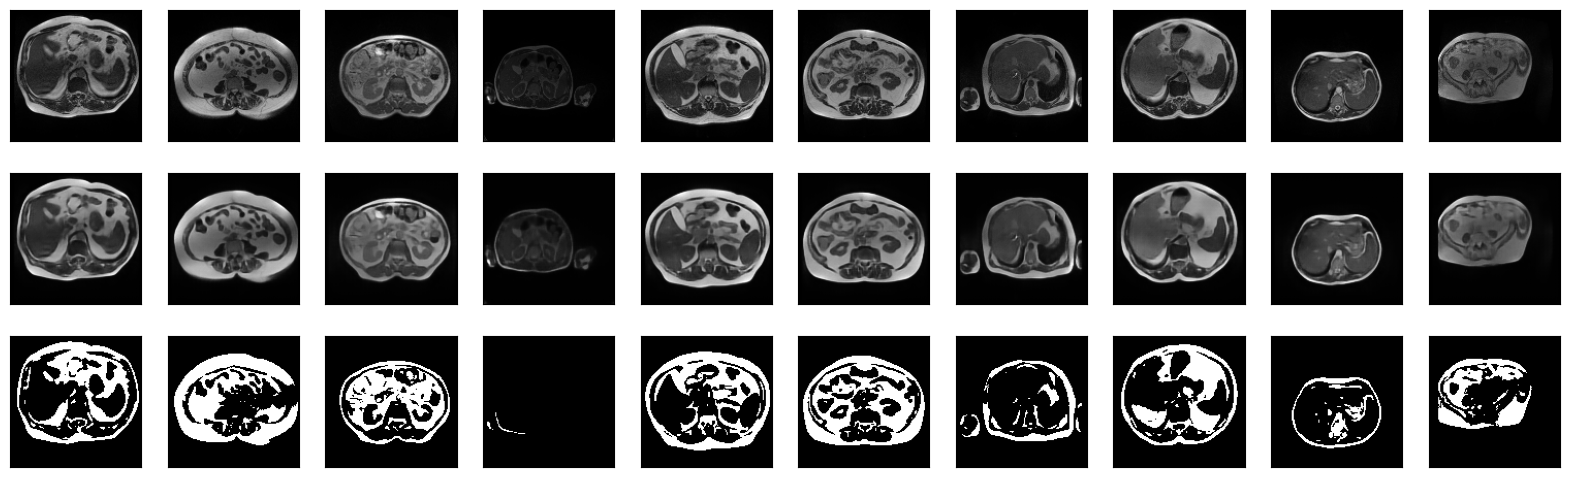

In [10]:
import matplotlib.pyplot as plt

def predict_and_create_masks(images, model, threshold=0.3):
    """
    Predict the output of the autoencoder and create masks based on a given threshold.

    Args:
        images (numpy.ndarray): Input images for prediction.
        model (tf.keras.Model): Trained autoencoder model.
        threshold (float): Threshold to apply to create binary masks.

    Returns:
        masks (numpy.ndarray): Binary masks of the predicted images.
    """
    # Predict the reconstructed images
    predicted_images = model.predict(images)

    # Apply threshold to create binary masks
    masks = predicted_images > threshold
    masks = masks.astype(np.uint8)  # Convert boolean masks to integers

    return masks

def plot_images(original_images, reconstructed_images, masks):
    """
    Plot original, reconstructed images, and their masks.

    Args:
        original_images (numpy.ndarray): Original grayscale images.
        reconstructed_images (numpy.ndarray): Reconstructed images from the autoencoder.
        masks (numpy.ndarray): Binary masks of the images.
    """
    n = 10  # Number of images to display
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed image
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display mask
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Use the autoencoder to predict on validation set
predicted_val_images = autoencoder.predict(X_val)

# Generate masks for the predicted images
val_masks = predict_and_create_masks(X_val, autoencoder)

# Plotting original validation images, their predictions, and masks
plot_images(X_val, predicted_val_images, val_masks)


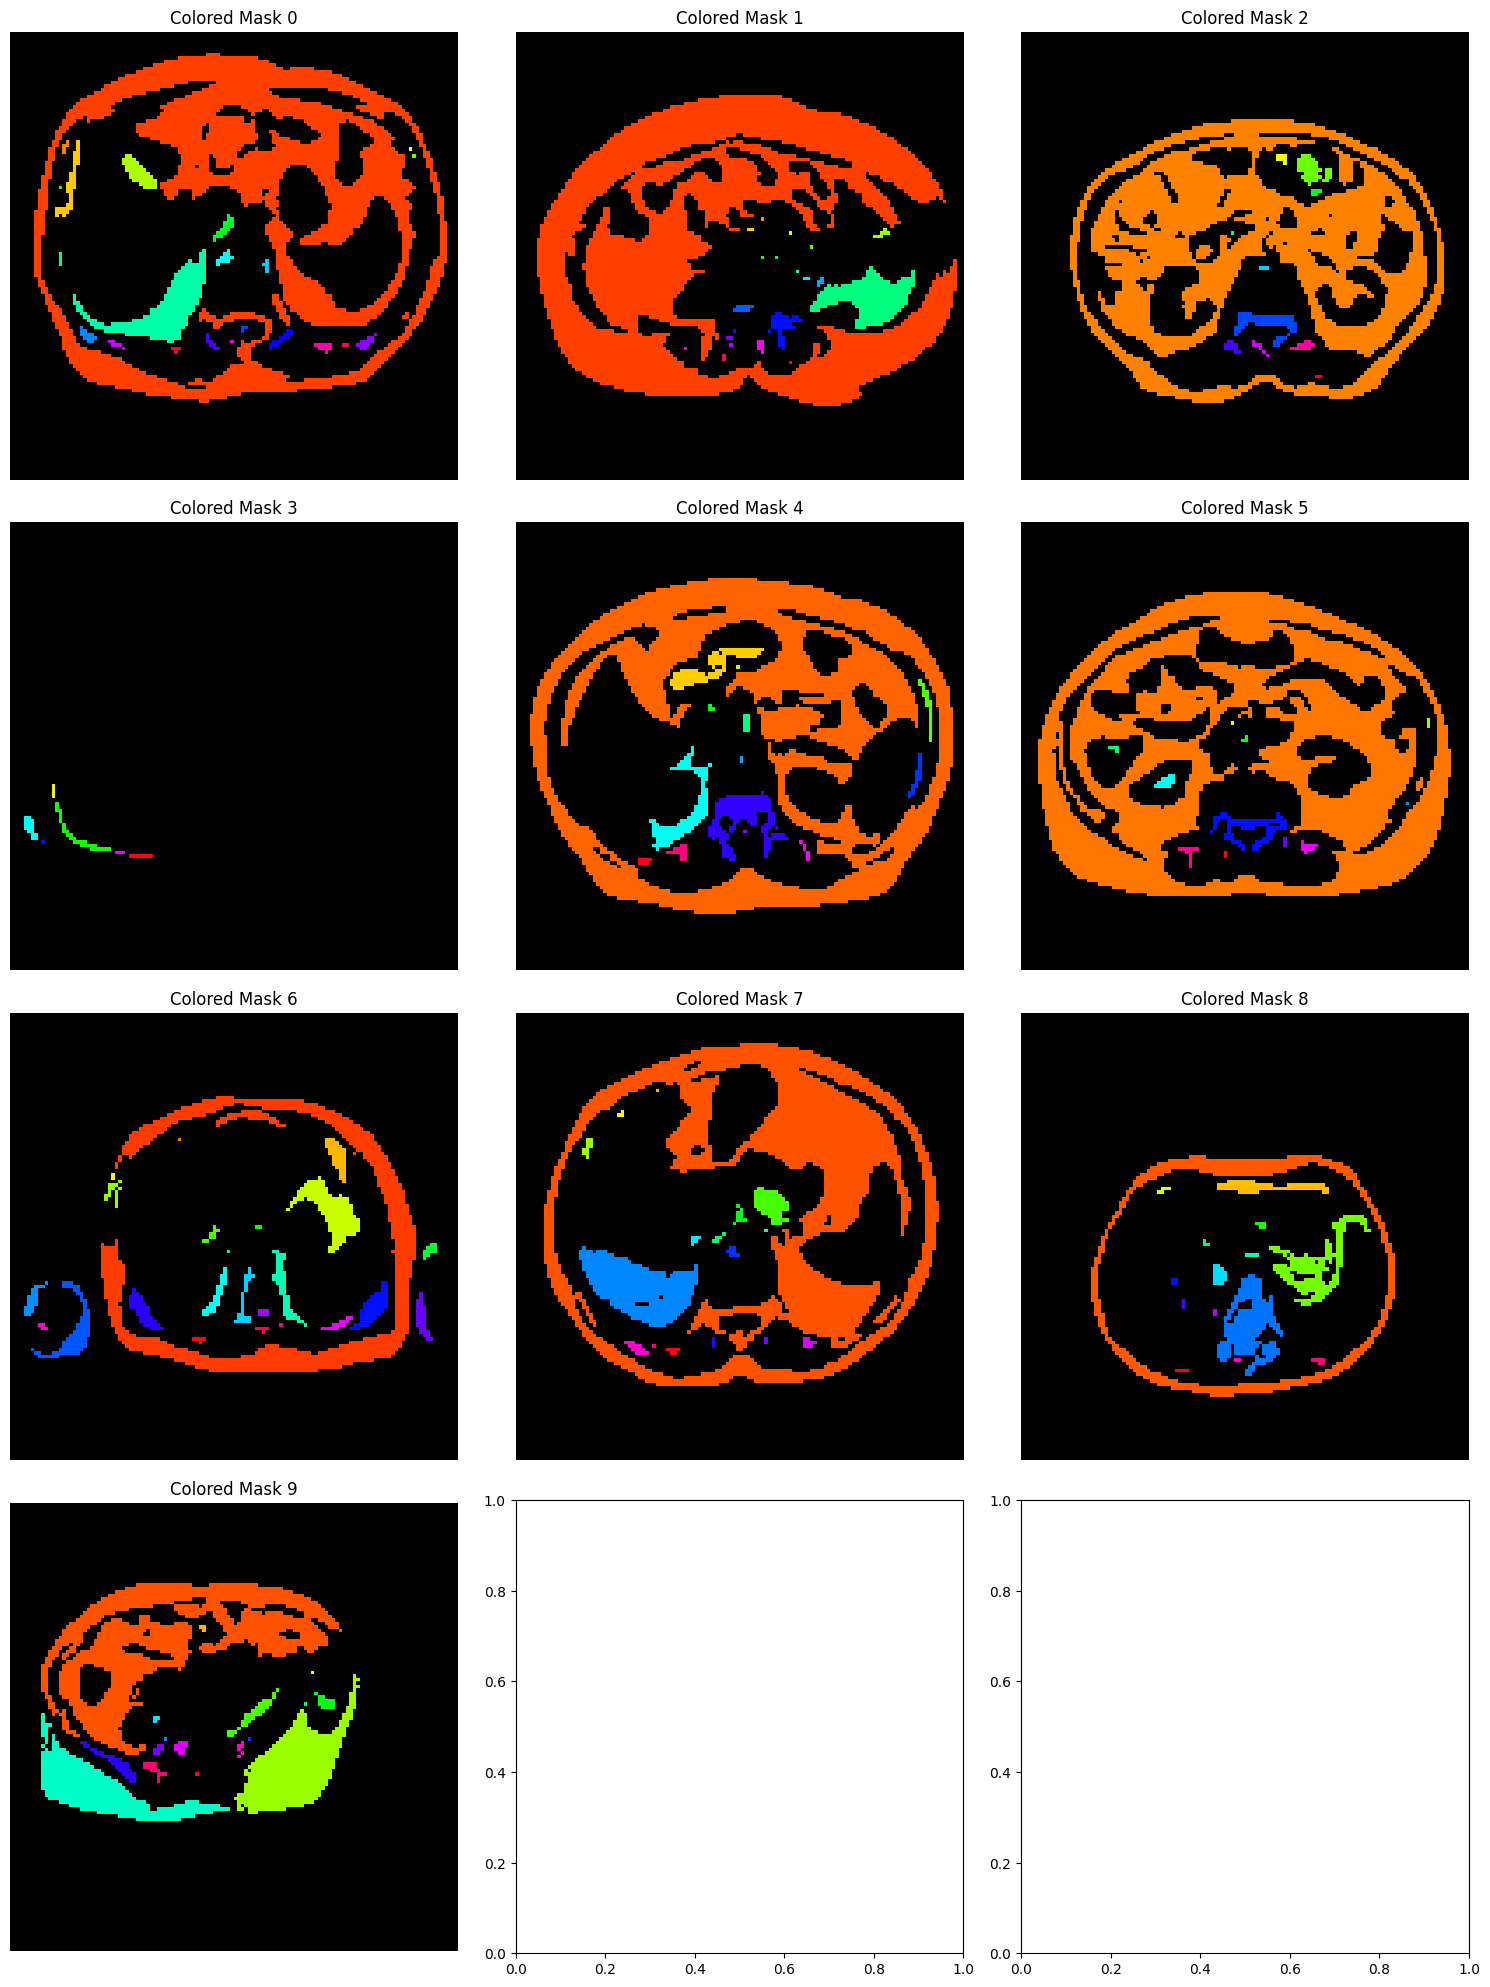

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def color_clusters(masks):
    colored_masks = []
    for mask in masks:
        num_labels, labels_im = cv2.connectedComponents(mask.astype(np.uint8))
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        hues = np.linspace(0, 179, num_labels, dtype=np.uint8)
        for label in range(1, num_labels):  # Skipping label 0 which is the background
            color = plt.cm.hsv(hues[label] / 179)[:3]  # Get RGB color from HSV colormap
            colored_mask[labels_im == label] = (np.array(color) * 255).astype(np.uint8)  # Scale to 0-255 RGB
        colored_masks.append(colored_mask)
    return np.array(colored_masks)


def display_images(images, titles, cmap=None, ncols=3):
    """
    Display multiple images in a grid.

    Args:
        images (list of numpy.ndarray): List of images to display.
        titles (list of str): Titles for each image.
        cmap (str, optional): Colormap to use for displaying images.
        ncols (int, optional): Number of columns in the display grid.
    """
    nrows = (len(images) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
    axes = axes.ravel()
    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(image, cmap=cmap)
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Example usage with a set of masks
masks = val_masks[:10]  # Assume these are binary masks from earlier predictions
colored_masks = color_clusters(masks)
display_images(list(colored_masks), ['Colored Mask {}'.format(i) for i in range(len(colored_masks))])


In [ ]:
assert(1==2)

In [ ]:
# Model summary
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 256, 256,  │        640 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_72       │ (None, 256, 256,  │          0 │ conv2d_76[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_72[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_73       │ (None, 256, 256,  │          0 │ conv2d_77[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 128, 128,  │          0 │ activation_73[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_74       │ (None, 128, 128,  │          0 │ conv2d_78[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_74[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_75       │ (None, 128, 128,  │          0 │ conv2d_79[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 64, 64,    │          0 │ activation_75[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_17… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_76       │ (None, 64, 64,    │          0 │ conv2d_80[0][0]   │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 64, 64,    │    590,080 │ activation_76[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_77       │ (None, 64, 64,    │          0 │ conv2d_81[0][0]   │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 32, 32,    │          0 │ activation_77[0]… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_18

 Total params: 93,092,366 (355.12 MB)

 Trainable params: 31,030,788 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,061,578 (236.75 MB)

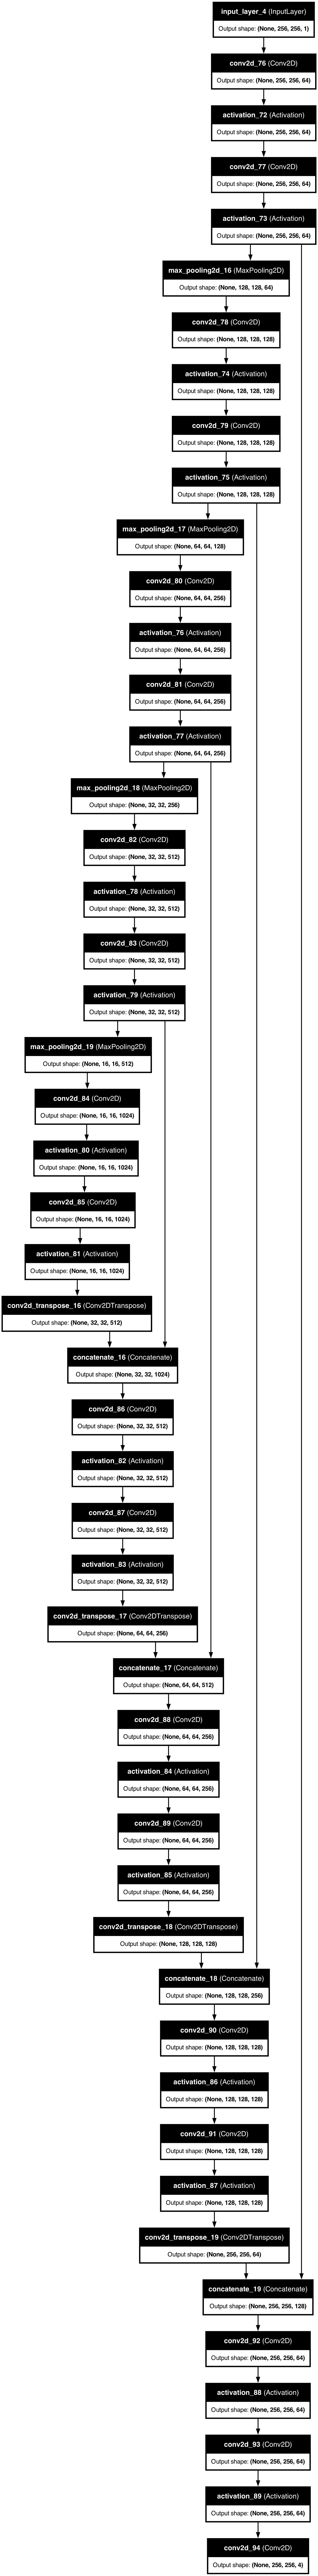

In [ ]:
from tensorflow.keras.utils import plot_model

# Generate a plot of the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# To display the image in Jupyter notebook (optional)
from IPython.display import Image
Image(filename='model_plot.png')